In [1]:
configs_dict=dict(
    Juul='configs.config_Juul_local',
    WomenInEngineering='configs.config_WomenInEngineering_local',
    ILLAE='configs.config_ILLAE_local'
)

saving_dir='/Users/habibkarbasian/Documents/_Courses/_Datasets/_Retweetability/analysis/'
# complete_dataset=True
complete_dataset=False

In [2]:
### init ###

import importlib

imp=importlib.import_module('_imports')
importlib.reload(imp)

util=importlib.import_module('_utils')
importlib.reload(util)

# %matplotlib inline

configs=dict()
for dataset, config in configs_dict.items():
    configs[dataset]=importlib.import_module(config)
    importlib.reload(configs[dataset])
    print('config {} is loaded.'.format(dataset))

config Juul is loaded.
config WomenInEngineering is loaded.
config ILLAE is loaded.


In [3]:
### reading cv ids for cv folds and input files ###

dfs_input=dict()

for dataset, c in configs.items():
    
    if c.directory['dataset']['type'] != 'xls':
        dfs_input[dataset] = imp.pd.read_csv('{}data/raw/{}.{}'.format(c.directory['master'],
                                                     c.directory['dataset']['filename'],
                                                     c.directory['dataset']['type']
                                                    )
                           , sep=c.directory['dataset']['sep'])

    if not complete_dataset:
        
        outer_ids = imp.pd.read_csv('{}{}'.format(c.directory['save'], 'cv_ids/outer_0.csv'))
        outer_ids.rename(columns={'id': c.id_name}, inplace=True)

        inner_ids = list()
        for i in range(c.inner):
            inner_ids.append(imp.pd.read_csv('{}cv_ids/inner_0_{}.csv'.format(c.directory['save'], i)))

        all_ids = imp.copy.deepcopy(inner_ids)
        all_ids=imp.pd.DataFrame()
        for item in inner_ids:
            all_ids=imp.pd.concat([all_ids, item], ignore_index=True, axis=0)
        all_ids.rename(columns={'id':c.id_name}, inplace=True)
        outer_ids.rename(columns={'id':c.id_name}, inplace=True)
        all_ids=imp.pd.concat([all_ids, outer_ids], ignore_index=True, axis=0)
        dfs_input[dataset]=imp.pd.merge(dfs_input[dataset], all_ids, on=c.id_name, how='right')     


    print('{} has {} items.'.format(dataset, len(dfs_input[dataset])))
    util.display_df(dfs_input[dataset].head(3))

Juul has 5318 items.


,in_reply_to_status_id,in_reply_to_screen_name,in_reply_to_user_id,retweet_count,favorite_count,tweet_created_at_date,tweet_created_at_hour,tweet_id,text,source,coordinates,name,screen_name,verified,friends_count,followers_count,favourites_count,statuses_count,description,profile_created_at_date,profile_created_at_hour,location,user_id,profile_image_url_https,profile_background_image_url_https,profile_banner_url,external_url,user_mentions,hashtags,external_media_type,external_media_url
0,1.033318e+18,Luc_Van_Daele,2.331103e+09,0,0,Aug 26 2018,08:10:26,1033627719890870273,#juul The fraudulent alien hand picture is n...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",NaN,Statler & Waldorf,Luc_Van_Daele,0,429,427,137,1052,International Vaping Dinosaur,Feb 07 2014,01:22:31,In Observer Status,2331103471,https://pbs.twimg.com/profile_images/822934414...,https://abs.twimg.com/images/themes/theme4/bg.gif,https://pbs.twimg.com/profile_banners/23311034...,NaN,"19809471, 1367532704",juul,photo,https://pbs.twimg.com/media/DlgueejWwAU_ezI.jpg
1,NaN,NaN,NaN,1,0,Aug 26 2018,07:20:32,1033615162308276224,#juullife https://t.co/isX9SjeDin,"<a href=""http://twitter.com/download/iphone"" r...",NaN,emma,3mma_02,0,9,4,0,5,lol,Aug 22 2018,05:14:40,NaN,1032133934908407808,https://pbs.twimg.com/profile_images/103213496...,NaN,https://pbs.twimg.com/profile_banners/10321339...,NaN,NaN,juullife,photo,https://pbs.twimg.com/media/Dlgjge1UcAAKEix.jpg
2,NaN,NaN,NaN,0,0,Nov 23 2018,05:31:15,1065840179372449792,https://t.co/5C0sBsOV0G Smoking vs Juuling #vi...,"<a href=""https://www.google.com/"" rel=""nofollo...",NaN,Hot Video,hotvideo,0,296,3893,1,62296,You can view and share Hot Popular Videos of t...,Dec 31 2008,05:05:18,US,18499660,https://pbs.twimg.com/profile_images/136568265...,https://abs.twimg.com/images/themes/theme4/bg.gif,NaN,http://en.ucc.blognawa.com/284123,NaN,"video, smoking, juuling, world, hotvideo, videos",NaN,NaN


WomenInEngineering has 3428 items.


,in_reply_to_status_id,in_reply_to_screen_name,in_reply_to_user_id,retweet_count,favorite_count,tweet_created_at_date,tweet_created_at_hour,tweet_id,text,source,coordinates,name,screen_name,verified,friends_count,followers_count,favourites_count,statuses_count,description,profile_created_at_date,profile_created_at_hour,location,user_id,profile_image_url_https,profile_background_image_url_https,profile_banner_url,external_url,user_mentions,hashtags,external_media_type,external_media_url
0,NaN,NaN,NaN,2,1,Jul 13 2018,01:55:39,1017588333877198849,We're thrilled to be co-hosting this upcoming ...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",NaN,innovation central sydney,icentralsydney,0,654,128,287,6,"We connect people, processes, data and things ...",Jun 04 2018,05:04:08,"Sydney, New South Wales",1003502638799831043,https://pbs.twimg.com/profile_images/101501820...,NaN,https://pbs.twimg.com/profile_banners/10035026...,NaN,NaN,WomeninEngineering,photo,https://pbs.twimg.com/media/Dh8y_EIV4AI0PTM.jpg
1,NaN,NaN,NaN,3,2,Jul 12 2018,22:08:00,1017531044571111424,Comment: Addressing the gender balance in engi...,"<a href=""https://ads-api.twitter.com"" rel=""nof...",NaN,Stemettes 💙 ★ # +,Stemettes,1,4569,36115,27997,25335,"Showing that girls do STEM (Sci, Tech, Eng & M...",Dec 04 2012,19:45:56,UK,989452274,https://pbs.twimg.com/profile_images/947775390...,https://abs.twimg.com/images/themes/theme15/bg...,https://pbs.twimg.com/profile_banners/98945227...,https://www.highwaysmagazine.co.uk/Comment-Add...,NaN,"STEM, WomenInSTEM, WomenInEngineering",NaN,NaN
2,NaN,NaN,NaN,1,0,Sep 20 2018,02:18:57,1042598962975440896,Elaine was checking out some existing storm in...,"<a href=""http://twitter.com/download/iphone"" r...",NaN,enggirlproblems,enggrlproblems,0,183,83,90,154,A career and lifestyle blog for women in engin...,Jan 18 2018,23:14:10,NaN,954129816957075459,https://pbs.twimg.com/profile_images/959892285...,NaN,https://pbs.twimg.com/profile_banners/95412981...,NaN,NaN,"AnEngineerWasHere, WomeninEngineering, stwm",photo,https://pbs.twimg.com/media/DngONiwX0AA6jWc.jpg


ILLAE has 10336 items.


,in_reply_to_status_id,in_reply_to_screen_name,in_reply_to_user_id,retweet_count,favorite_count,tweet_created_at_date,tweet_created_at_hour,tweet_id,text,source,coordinates,name,screen_name,verified,friends_count,followers_count,favourites_count,statuses_count,description,profile_created_at_date,profile_created_at_hour,location,user_id,profile_image_url_https,profile_background_image_url_https,profile_banner_url,external_url,user_mentions,hashtags,external_media_type,external_media_url
0,NaN,NaN,NaN,1,0,Aug 27 2015,21:02:37,637007331574812673,We're so proud of our mentors. Earlier this mo...,"<a href=""http://www.hootsuite.com"" rel=""nofoll...",NaN,SparkProgramLA,SparkProgramLA,0,196,253,117,672,"Every day, we foster relationships between mid...",Sep 11 2013,17:42:45,"Los Angeles, CA",1854956568,https://pbs.twimg.com/profile_images/719566009...,https://pbs.twimg.com/profile_background_image...,https://pbs.twimg.com/profile_banners/18549565...,NaN,"1719657061, 135266722",ILookLikeAnEngineer,NaN,NaN
1,NaN,NaN,NaN,1,3,Aug 27 2015,21:24:57,637012950495031296,#Ilooklikeanengineer http://t.co/Zrz7y3Vt3X,"<a href=""http://www.apple.com"" rel=""nofollow"">...",NaN,kate,Szkolnik,0,1287,13,2,3,NaN,May 06 2011,13:22:01,NaN,294060143,https://pbs.twimg.com/profile_images/134470334...,https://abs.twimg.com/images/themes/theme1/bg.png,NaN,NaN,NaN,Ilooklikeanengineer,photo,https://pbs.twimg.com/media/CNcf5zwUEAAXhBC.jpg
2,NaN,kstate_wie,2.677363e+09,2,4,Aug 27 2015,21:25:08,637012998473670656,@kstate_wie @KStateEngg #ILookLikeAnEngineer h...,"<a href=""http://twitter.com/download/iphone"" r...",NaN,Spency Spenc,spencer_slane,0,464,494,2341,8345,Mechanical Engineer - BAJA TREASURER,Oct 02 2011,14:36:49,KSU,383790528,https://pbs.twimg.com/profile_images/780423411...,https://abs.twimg.com/images/themes/theme1/bg.png,https://pbs.twimg.com/profile_banners/38379052...,NaN,"2677362781, 32296630",ILookLikeAnEngineer,photo,https://pbs.twimg.com/media/CNcf7_XVEAAjLQg.jpg


In [5]:
for name, df in dfs_input.items():
    df['tweet_created_at_date']=imp.pd.to_datetime(df['tweet_created_at_date'], format='%b %d %Y')
    print('{} - min {} - max {}'.format(
        name,
        imp.np.min(df['tweet_created_at_date']), 
        imp.np.max(df['tweet_created_at_date']))
         )

Juul - min 2018-04-24 00:00:00 - max 2019-03-26 00:00:00
WomenInEngineering - min 2018-05-01 00:00:00 - max 2018-11-01 00:00:00
ILLAE - min 2015-08-08 00:00:00 - max 2015-10-15 00:00:00


In [6]:
dfs_hashtags_stat=dict()

for dataset_name in configs_dict.keys():
    df_input = dfs_input[dataset_name]

    hashtags_freq=dict()
    for hashtags in df_input['hashtags']:
        if not isinstance(hashtags, str):
            splits=['']
        else:
            splits=hashtags.split(',')
        hashtag_unique=set()

        for split in splits:
            hashtag=split.strip().lower()
            hashtag_unique.add(hashtag)
        for hashtag in hashtag_unique:
            hashtags_freq[hashtag]=hashtags_freq.get(hashtag, 0)+1

    hashtags_freq_sorted=sorted(hashtags_freq.items(), key=imp.operator.itemgetter(1), reverse=True)        
    hashtags_freq_perc=imp.pd.DataFrame(hashtags_freq_sorted, columns=['Hashtag', '% of tweets'])
    hashtags_freq_perc['% of tweets']=hashtags_freq_perc['% of tweets']/len(df_input)
    
    hashtags_freq_perc.to_csv('{}hashtags_stat_{}.csv'.format(saving_dir,
                                                              dataset_name
                                                             ),
                              index=False)
    dfs_hashtags_stat[dataset_name]=hashtags_freq_perc
    print('number of hashtags = {}'.format(len(hashtags_freq)))
    print('number of tweets = {}'.format(len(df_input)))
    util.display_df(hashtags_freq_perc.head(10))

number of hashtags = 5536
number of tweets = 5318


,Hashtag,% of tweets
0,juul,0.864235
1,vaping,0.169989
2,vape,0.166792
3,juuling,0.086499
4,ecig,0.081422
5,ecigs,0.072208
6,cbd,0.047386
7,juulgang,0.043813
8,vapefam,0.043625
9,vapelife,0.043249


number of hashtags = 2808
number of tweets = 3428


,Hashtag,% of tweets
0,womeninengineering,1.000000
1,womeninstem,0.273629
2,inwed18,0.221995
3,raisingthebar,0.130980
4,stem,0.128938
5,womenintech,0.112894
6,engineering,0.100058
7,womeninscience,0.047258
8,engineer,0.023629
9,women,0.022170


number of hashtags = 2757
number of tweets = 10336


,Hashtag,% of tweets
0,ilooklikeanengineer,0.974265
1,stem,0.026896
2,womenintech,0.025929
3,engineering,0.018286
4,tech,0.017512
5,looklikeanengineer,0.016254
6,women,0.015383
7,adalovelaceday,0.011320
8,news,0.010642
9,socialmedia,0.010062


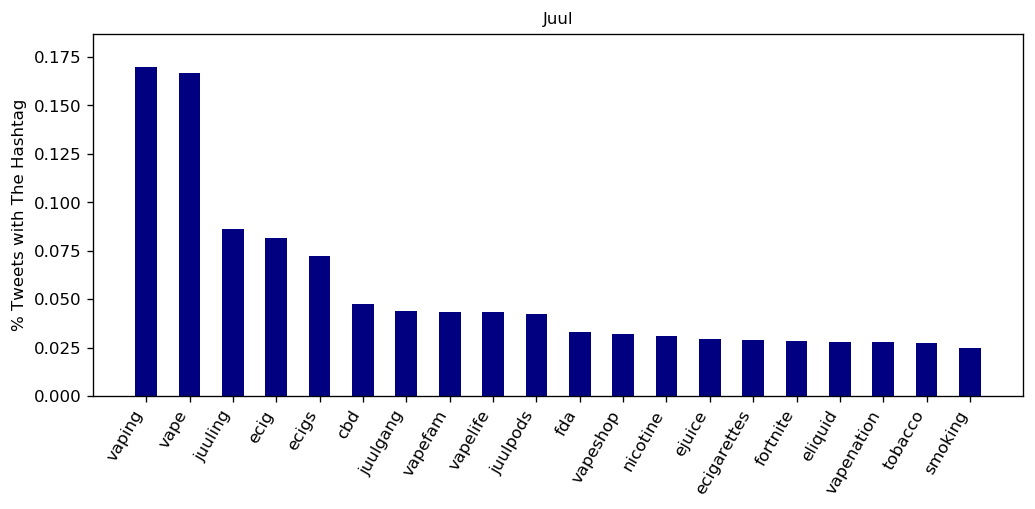

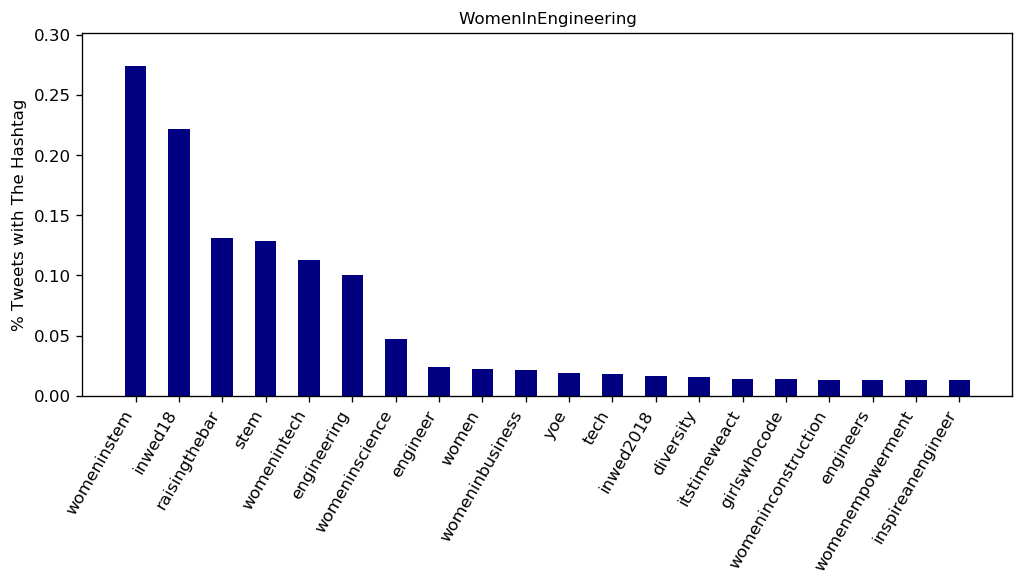

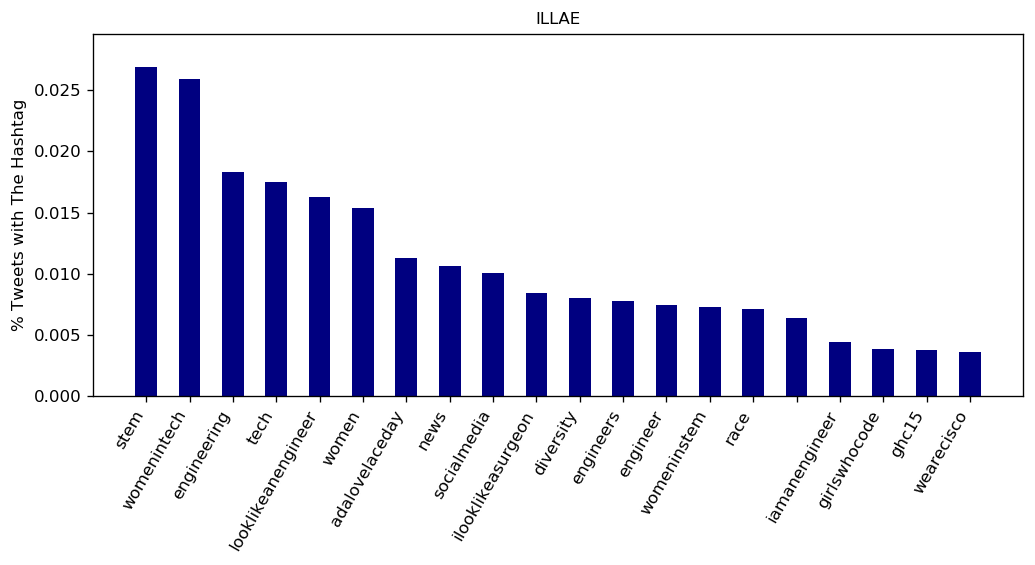

In [7]:
ntop = 20

for dataset_name, hashtags_freq_perc in dfs_hashtags_stat.items():
    hashtags_freq_perc_top = hashtags_freq_perc[1:ntop+1]
    # Plot
    # fig, (ax1, ax2) = imp.plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)
    fig, ax1 = imp.plt.subplots(1, 1, figsize=(10, 4), dpi=120, sharey=True)

    ax1.bar(range(len(hashtags_freq_perc_top)), list(hashtags_freq_perc_top.loc[:,'% of tweets']), width=.5, color='navy')

    ax1.set_xticks(range(len(hashtags_freq_perc_top)))
    # tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
    # ax1.xaxis.set_major_formatter(tick_formatter)
    ax1.set_xticklabels(hashtags_freq_perc_top['Hashtag'], rotation=60, horizontalalignment= 'right')

    ax1.set_title(dataset_name, fontdict=dict(size=10))
    ax1.set_ylabel('% Tweets with The Hashtag')
    ax1.set_ylim(0, imp.np.max(list(hashtags_freq_perc_top.loc[:,'% of tweets'])) * 1.1)
    imp.plt.savefig('{}top_{}_hashtags_{}.png'.format(saving_dir,
                                                  ntop,
                                                  dataset_name
                                                 ), 
                bbox_inches='tight')

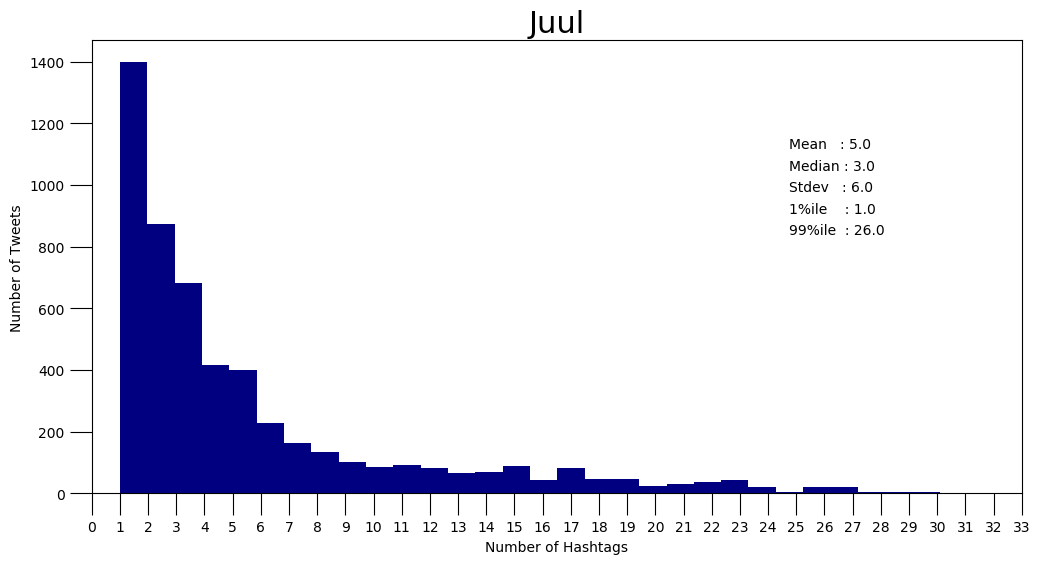

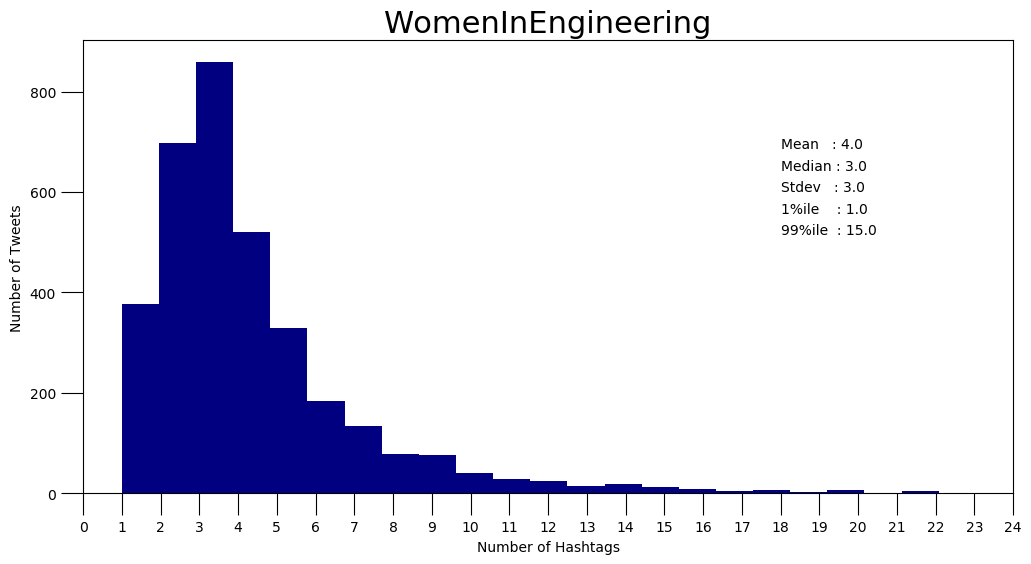

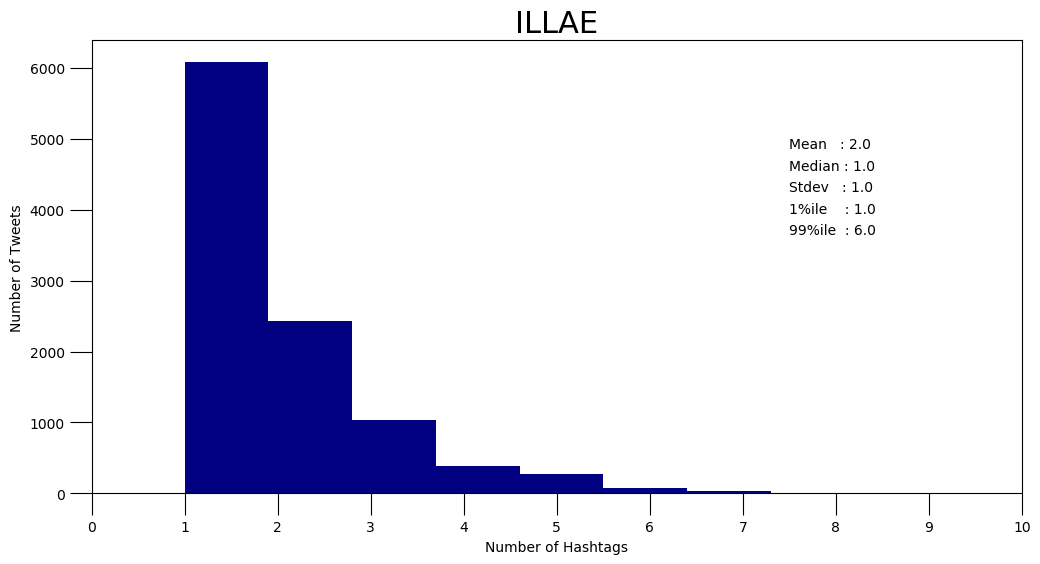

In [16]:
# Histogram Plot

doc_lens_dict=dict()
max_percentage=-1

for dataset_name, df_input in dfs_input.items():
    # dataset_name='WomenIn'
    df_input = dfs_input[dataset_name]

    doc_lens=[len(hashtags.split(',')) if isinstance(hashtags, str) else 1 for hashtags in df_input['hashtags']]
    doc_lens_dict[dataset_name]=doc_lens


    doc_size = int(imp.np.max(doc_lens))
    x_offset = 0.75*doc_size
    max_freq=max(imp.np.histogram(doc_lens, bins=list(range(doc_size)))[0])
    max_percentage=max(max_percentage, max_freq/len(df_input))
    y_offset = 0.8*max_freq
    y_delta = 0.05*max_freq

    imp.plt.figure(figsize=(12,6), dpi=100)
    imp.plt.hist(doc_lens, bins = doc_size , color='navy')
    imp.plt.text(x_offset, y_offset, "Mean   : " + str(round(imp.np.mean(doc_lens))))
    imp.plt.text(x_offset, y_offset - 1*y_delta, "Median : " + str(round(imp.np.median(doc_lens))))
    imp.plt.text(x_offset, y_offset - 2*y_delta, "Stdev   : " + str(round(imp.np.std(doc_lens))))
    imp.plt.text(x_offset, y_offset - 3*y_delta, "1%ile    : " + str(round(imp.np.quantile(doc_lens, q=0.01))))
    imp.plt.text(x_offset, y_offset - 4*y_delta, "99%ile  : " + str(round(imp.np.quantile(doc_lens, q=0.99))))

    imp.plt.gca().set(xlim=(0, doc_size), ylabel='Number of Tweets', xlabel='Number of Hashtags')
    imp.plt.tick_params(size=16)
    imp.plt.xticks(imp.np.linspace(0, doc_size, doc_size+1))
    imp.plt.title(dataset_name, fontdict=dict(size=22))
    imp.plt.show()

In [10]:
y_limit = 0

for df in dfs_hashtags_stat.values():
    y_limit=max(df.loc[1,'% of tweets'], y_limit)
    
y_limit    

0.2736289381563594

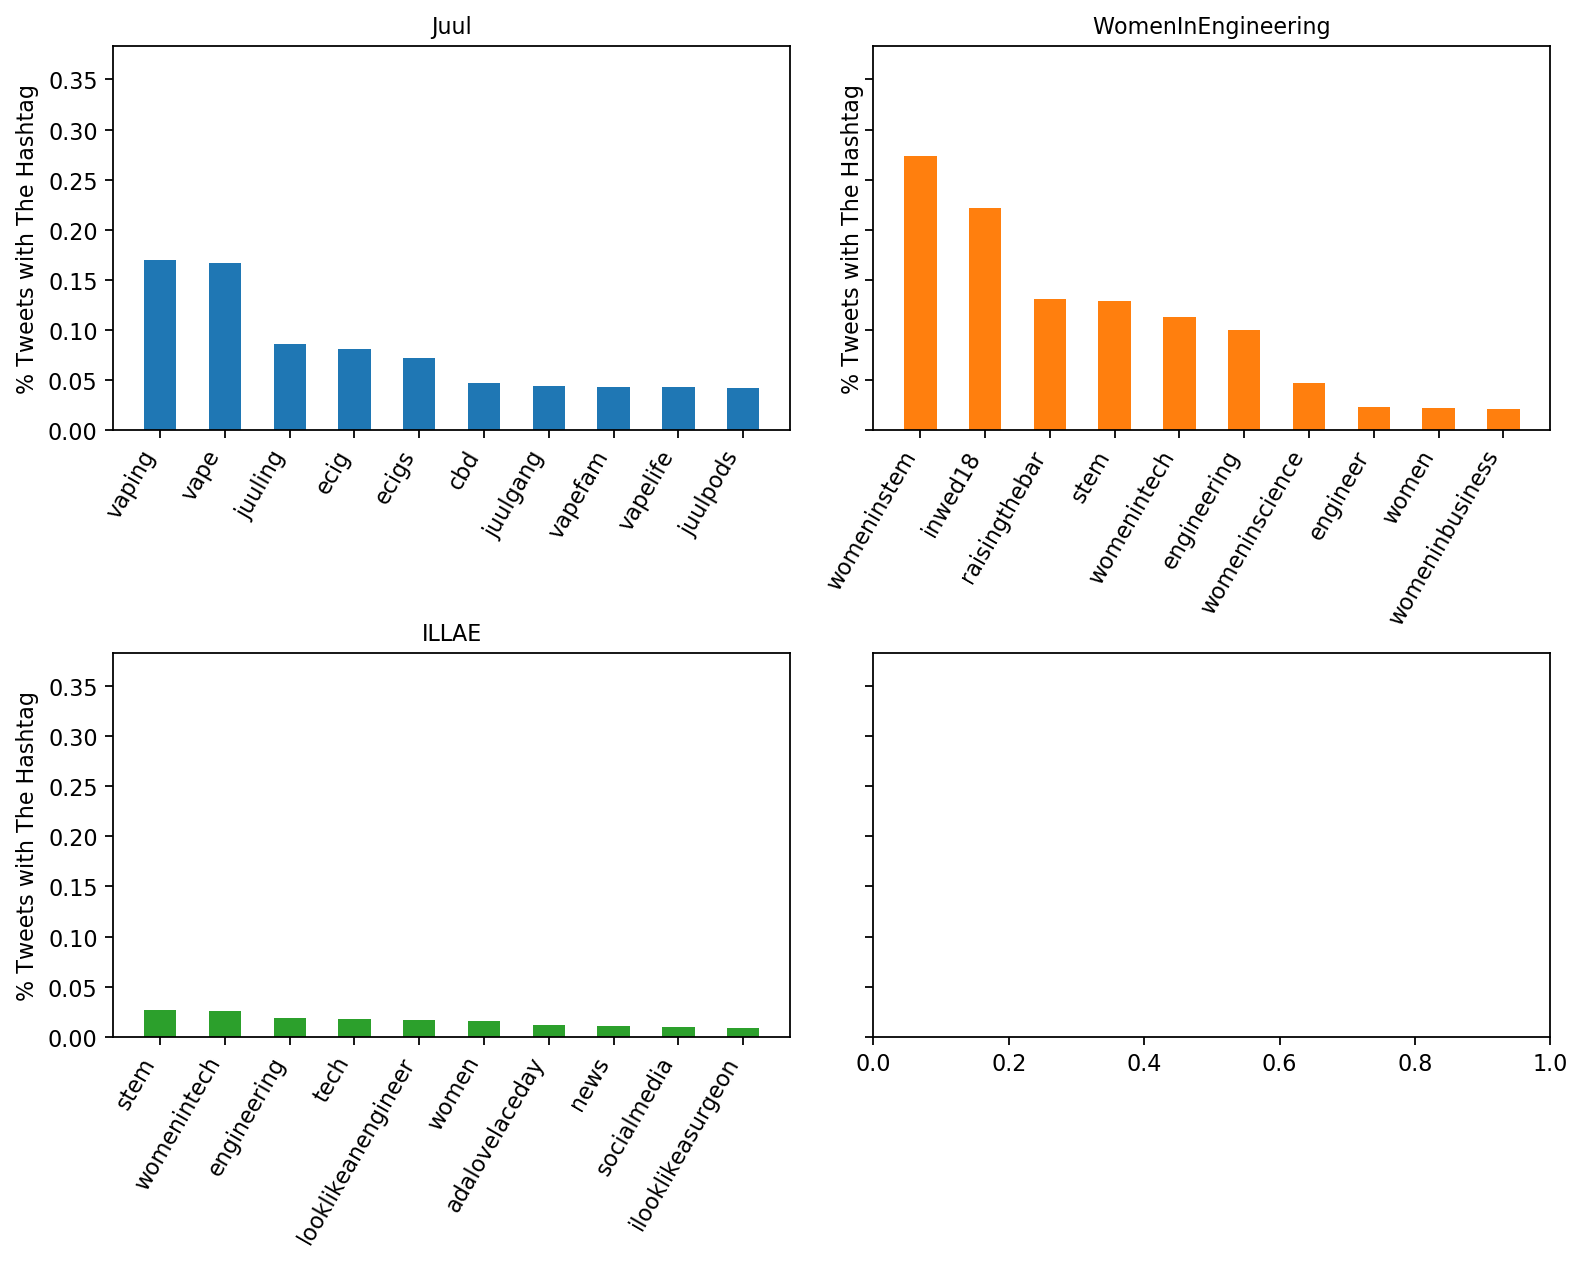

In [11]:
# number of top hashtags
ntop=10


cols = [color for name, color in imp.mcolors.TABLEAU_COLORS.items()]

fig, ax = imp.plt.subplots(2, 2, figsize=(10, 8), dpi=160, sharey=True)

for index, (name, df) in enumerate(dfs_hashtags_stat.items()):
    
    hashtags_freq_perc_top=df[1:ntop+1]

    ax[index//2, index%2].bar(range(len(hashtags_freq_perc_top)), 
                             list(hashtags_freq_perc_top.loc[:,'% of tweets']), 
                             width=.5, 
                             color=cols[index]
                            )

    ax[index//2, index%2].set_xticks(range(len(hashtags_freq_perc_top)))
    # tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
    # ax1.xaxis.set_major_formatter(tick_formatter)
    ax[index//2, index%2].set_xticklabels(hashtags_freq_perc_top['Hashtag'], rotation=60, horizontalalignment= 'right')

    ax[index//2, index%2].set_title(name, fontdict=dict(size=10))
    ax[index//2, index%2].set_ylabel('% Tweets with The Hashtag')
    ax[index//2, index%2].set_ylim(0, y_limit* 1.4)
imp.plt.tight_layout()    

In [13]:
max_percentage

0.2736289381563594

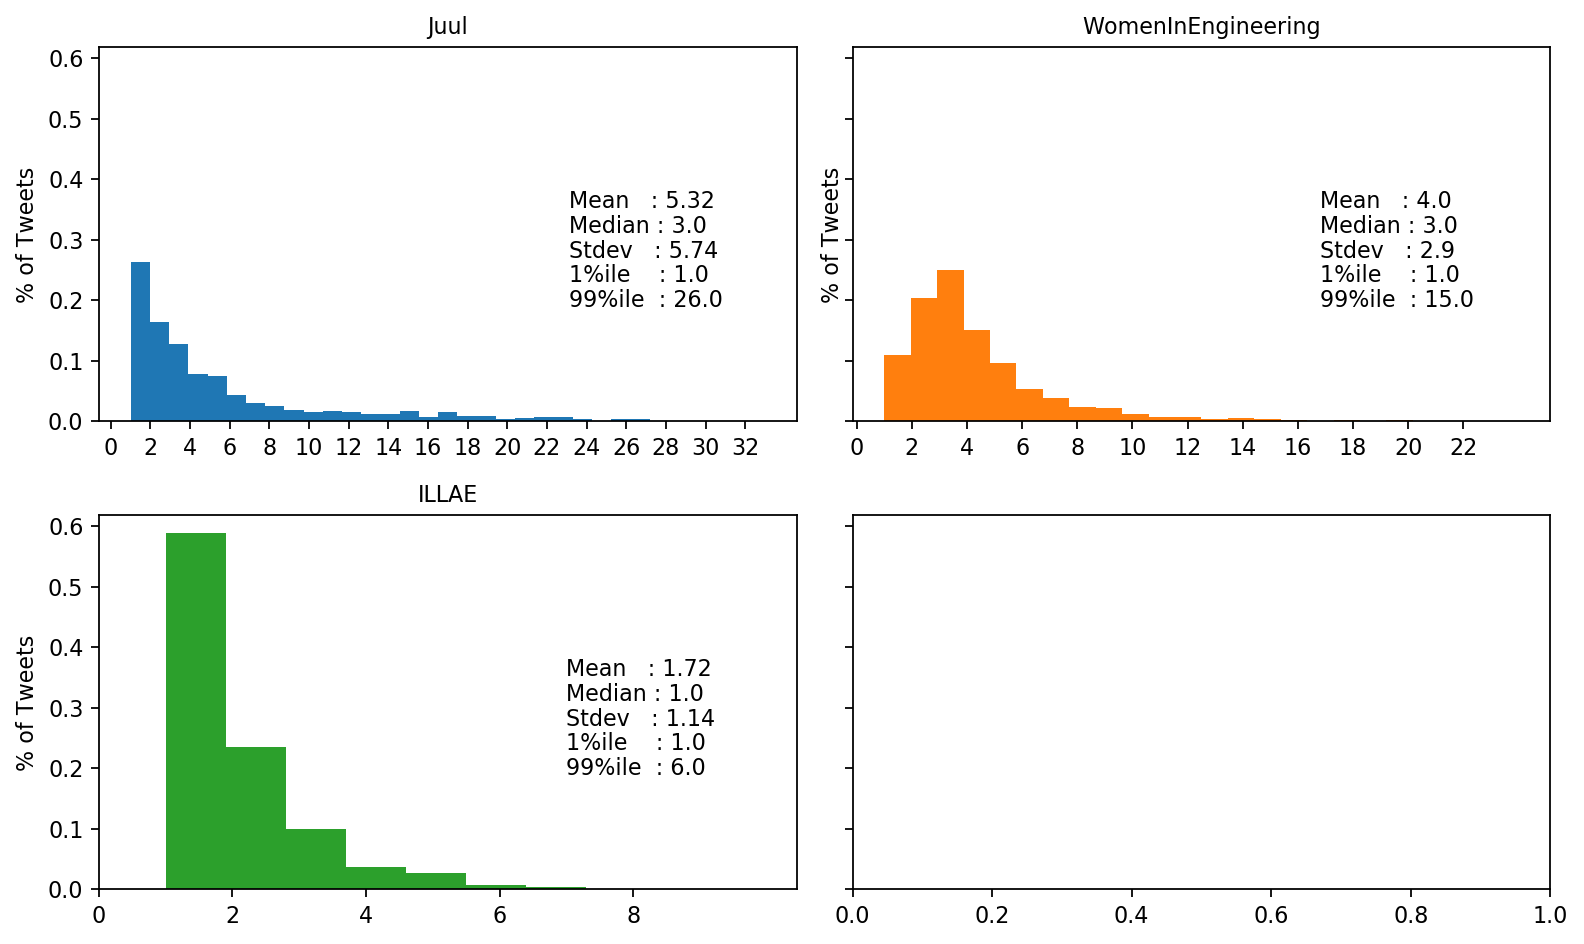

In [19]:
x_limit = max(list(map(max, doc_lens_dict.values())))

fig, ax = imp.plt.subplots(2, 2, figsize=(10, 6), dpi=160, sharey=True)

for index, (name, doc_lens) in enumerate(doc_lens_dict.items()):
#     doc_size = x_limit
#     print (item)
#     doc_lens, weights = item
    doc_size = int(max(doc_lens))
#     x_offset = 
#     y_offset = 15000
#     y_delta = 1500
    x_offset = 0.7*doc_size
    y_offset = 0.6*max_percentage
    y_delta = 0.07 * max_percentage
    
    weights = imp.np.ones_like(doc_lens)/float(len(doc_lens))
    ax[index//2, index%2].hist(doc_lens, bins = doc_size ,color=cols[index], weights=weights)
    ax[index//2, index%2].text(x_offset, y_offset, "Mean   : " + str(round(imp.np.mean(doc_lens), 2)))
    ax[index//2, index%2].text(x_offset, y_offset - 1*y_delta, "Median : " + str(round(imp.np.median(doc_lens))))
    ax[index//2, index%2].text(x_offset, y_offset - 2*y_delta, "Stdev   : " + str(round(imp.np.std(doc_lens), 2)))
    ax[index//2, index%2].text(x_offset, y_offset - 3*y_delta, "1%ile    : " + str(round(imp.np.quantile(doc_lens, q=0.01), 2)))
    ax[index//2, index%2].text(x_offset, y_offset - 4*y_delta, "99%ile  : " + str(round(imp.np.quantile(doc_lens, q=0.99), 2)))

    ax[index//2, index%2].set_xticks(range(0, doc_size, 2))
    ax[index//2, index%2].set_title(name, fontdict=dict(size=10))
    ax[index//2, index%2].set_ylabel('% of Tweets')    
#     ax[index/2, index%2].gca().set(xlim=(0, doc_size), ylabel='Number of Tweets', xlabel='Number of Hashtags')
#     ax[index/2, index%2].tick_params(size=16)
#     ax[index/2, index%2].xticks(np.linspace(0, doc_size, doc_size+1))
#     ax[index/2, index%2].title(name, fontdict=dict(size=22))

imp.plt.tight_layout() 